0. Data Popeline
1. Baseline model: train a simple CNN from scratch
2. Transfer learning: pretained ConvNet as a feature extractor
3. Transfer learning: fine-tune a pretrained ConvNet
4. Test Accuracy & visuale predictions

In [1]:
# Enable TensorFlow 2.0
import tensorflow as tf

# Verify TensorFlow version
print(tf.__version__)

# Create a constant tensor
hello = tf.constant('Hello, TensorFlow!')

# Use tf.print instead of session run
tf.print(hello)


2.17.0
Hello, TensorFlow!


In [2]:
#import tensorflow
import tensorflow as tf
tf.__version__

'2.17.0'

In [72]:
# Import TensorFlow dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


# Import Keras
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Import Numpy
import numpy as np

# Import Matplotlib
import matplotlib.pyplot as plt

In [4]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="tf_flowers",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # train, validation, test split of 8:1:1
    with_info=True,
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
print("Total number of samples:", metadata.splits["train"].num_examples)


Total number of samples: 3670


In [6]:
num_class = metadata.features["label"].num_classes
num_train = len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_class)
print("Number of training samples:", num_train)
print("Number of validation samples:", num_validation)
print("Number of test samples:", num_test)


Number of classes: 5
Number of training samples: 2936
Number of validation samples: 367
Number of test samples: 367


In [7]:
# Inspect datasets before data processing
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [8]:
# Get labels / class names
class_names = np.array(metadata.features["label"].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


Let's take a look a few of the flower images

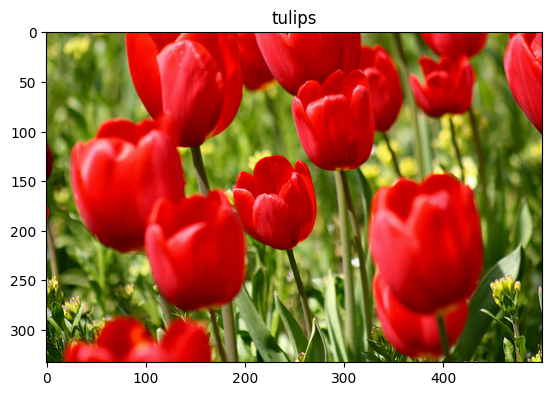

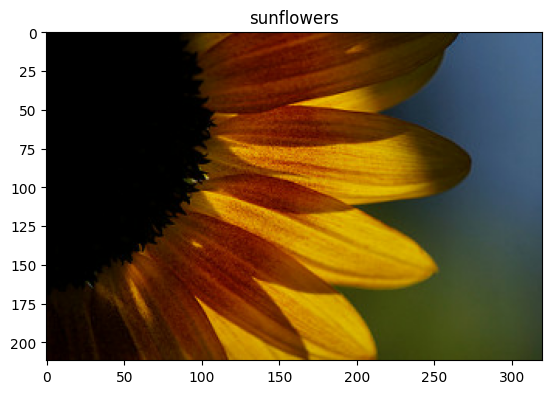

In [9]:
label_names = metadata.features["label"].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))

In [10]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  imaag = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [13]:
train = train.map(augment_data)

Shuffle and Batch Dataset

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [15]:
# Inspect datasets after data processing
print(train_batches)
print(validation_batches)
print(test_batches)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [16]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

Training

In [17]:
#Set Traiing Prameters
NUM_EPOCHS = 10
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = num_validation // BATCH_SIZE

In [18]:
# Display training curves
def display_training_curves(training, validation, title, subplot):
  acc = history.history[training]
  val_acc = history.history[validation]

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(NUM_EPOCHS)

  plt.figure(epochs_range, acc, label='Training Accuracy')
  plt.figure(epochs_range, val_acc, label='Val Accuracy')
  plt.title(title)
  plt.legend(loc='upper left')
  plt.figure()

  plt.show()

Baseline - Train from Scratch
Train Very simple CNN model and use the accuracy metrics as a baseline to compare with transfer learning results

Create Model

In [19]:
def build_model_from_scratch():

  model = Sequential([
  # Must define the input shape in the first layer of the nural network
  Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=IMG_SHAPE),
  MaxPooling2D(pool_size=2),

  Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=2),

  Flatten(),
  Dense(512, activation='relu'),
  Dense(num_class, activation='softmax')
  ])

  return model


In [20]:
simple_cnn_model = build_model_from_scratch()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
simple_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     102,760,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,782,917 (392.09 MB)

 Trainable params: 102,782,917 (392.09 MB)

 Non-trainable params: 0 (0.00 B)

Compile and Train the Model

In [37]:
import matplotlib.pyplot as plt
def train_model(model):

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(train_batches,
                      epochs=NUM_EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=validation_batches,
                      validation_steps=VALIDATION_STEPS)
  return history



def display_training_curves(training_accuracy, validation_accuracy, training_loss, validation_loss, title, subplot):
    epochs = range(len(training_accuracy))

    plt.figure(figsize=(12, 8))
    plt.subplot(subplot)
    plt.plot(epochs, training_accuracy, 'r', label='Training accuracy')
    plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(subplot + 1)
    plt.plot(epochs, training_loss, 'r', label='Training loss')
    plt.plot(epochs, validation_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()




In [23]:
%%time
history = train_model(simple_cnn_model)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.2870 - loss: 4.5924 - val_accuracy: 0.4716 - val_loss: 1.2514
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4518 - loss: 1.2733 - val_accuracy: 0.5433 - val_loss: 1.1588
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.5059 - loss: 1.2274 - val_accuracy: 0.5164 - val_loss: 1.1704
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5404 - loss: 1.1102 - val_accuracy: 0.5701 - val_loss: 1.0775
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.6121 - loss: 1.0214 - val_accuracy: 0.5851 - val_loss: 1.1134
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6469 - loss: 0.9263 - val_accuracy: 0.5612 - val_loss: 1.1322
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.6595 - loss: 0.8601 - val_accuracy: 0.5910 - val_loss: 1.2068
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7063 - loss: 0.7555 - val_accuracy: 0.6030

ValueError: num must be an integer with 1 <= num <= 1, not 2

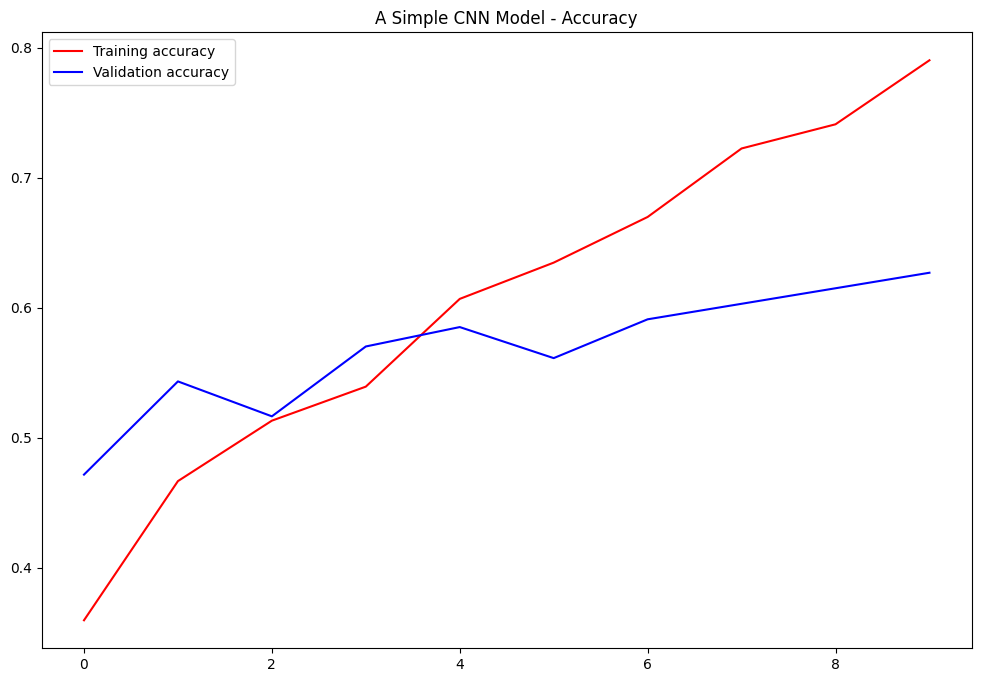

In [51]:
# Display training curve
display_training_curves(history.history['accuracy'], history.history['val_accuracy'],
                        history.history['loss'], history.history['val_loss'],
                        title="A Simple CNN Model", subplot=111)



##Transfer Learning
Now we can see how transferlearning can achieve better results.

##Feature Extractor
Use MobileNetV2

 Create base model

In [67]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [52]:
IMG_SHAPE = (224, 224, 3)

In [59]:
# Create base model from tf.keras pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         weights='imagenet',
                         include_top=False)

Freeze all layers of the moodel

In [60]:
base_model.trainable = False

In [65]:
num_class = 10

In [71]:
inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_class, activation='softmax')(x)
model = Model(inputs, outputs)

NameError: name 'Model' is not defined

Add a classifier head

Create a new model for adding a classifier on top of the base model

In [61]:
def build_mobilenetv2_model(base_model):
    model = Sequential([
        base_model,
        Conv2D(32, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(num_class, activation='softmax')
    ])
    return model

In [62]:
model = build_mobilenetv2_model(base_model)

Compile the Model

In [63]:
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the model

In [74]:
%%time
history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_batches,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.5888 - loss: 1.3365 - val_accuracy: 0.8665 - val_loss: 0.4104
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.7987 - loss: 0.5179 - val_accuracy: 0.8776 - val_loss: 0.4094
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8152 - loss: 0.4599 - val_accuracy: 0.8896 - val_loss: 0.4315
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8469 - loss: 0.4212 - val_accuracy: 0.8896 - val_loss: 0.3802
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8568 - loss: 0.3577 - val_accuracy: 0.8746 - val_loss: 0.3968
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8805 - loss: 0.3245 - val_accuracy: 0.8955 - val_loss: 0.3944
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8887 - loss: 0.2893 - val_accuracy: 0.8746 - val_loss: 0.5080
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8896 - loss: 0.2989 - val_accuracy: 0.8925 -

In [78]:
# Display training curve
def display_training_curves(training_loss, validation_loss, title, subplot):
  plt.subplot(subplot)
  plt.plot(training_loss, label='Training Loss')
  plt.plot(validation_loss, label='Validation Loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Fine tuning

Unfreeze top layers for fine tuning

In [79]:
#Unfreeze all layers in base model
base_model.trainable = True

In [80]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [81]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [83]:
model.compile(loss='sparse_categorical_crossentropy',
               optimizer=Adam(1e-5),
               metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,821 (10.02 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 396,544 (1.51 MB)

Continue to train the model


In [85]:
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #200

In [86]:
%%time
history_fine = model.fit(train_batches,
                         epochs=TOTAL_EPOCHS,        #20
                         initial_epoch=INITIAL_EPOCHS, #10
                         validation_data=validation_batches,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS)

Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.7368 - loss: 0.7795 - val_accuracy: 0.8864 - val_loss: 0.4858
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.8000 - loss: 0.5151 - val_accuracy: 0.8985 - val_loss: 0.5022
Epoch 13/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8483 - loss: 0.4344 - val_accuracy: 0.9134 - val_loss: 0.4582
Epoch 14/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8415 - loss: 0.4273 - val_accuracy: 0.8985 - val_loss: 0.4827
Epoch 15/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8564 - loss: 0.3622 - val_accuracy: 0.9104 - val_loss: 0.3880
Epoch 16/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8625 - loss: 0.3627 - val_accuracy: 0.8985 - val_loss: 0.4675
Epoch 17/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8788 - loss: 0.3274 - val_accuracy: 0.8985 - val_loss: 0.4484
Epoch 18/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8800 - loss: 0.3214 - val_accuracy: 

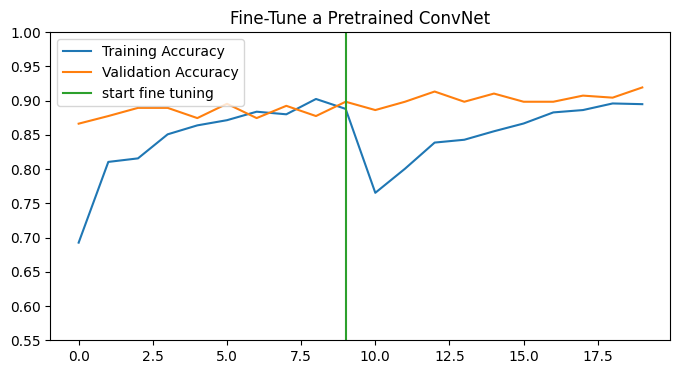

In [90]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([NUM_EPOCHS-1, NUM_EPOCHS -1], plt.ylim(ymin=0.55), label='start fine tuning')
plt.title("Fine-Tune a Pretrained ConvNet")
plt.legend(loc='upper left')





Test Accuracy

In [91]:
#Evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

#print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9182561039924622


Visualize predictions

In [96]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Then we visualize some of the images and compare weather the prdicted labels equal to the true labels.

Text(0.5, 0.98, 'Model Predictions')

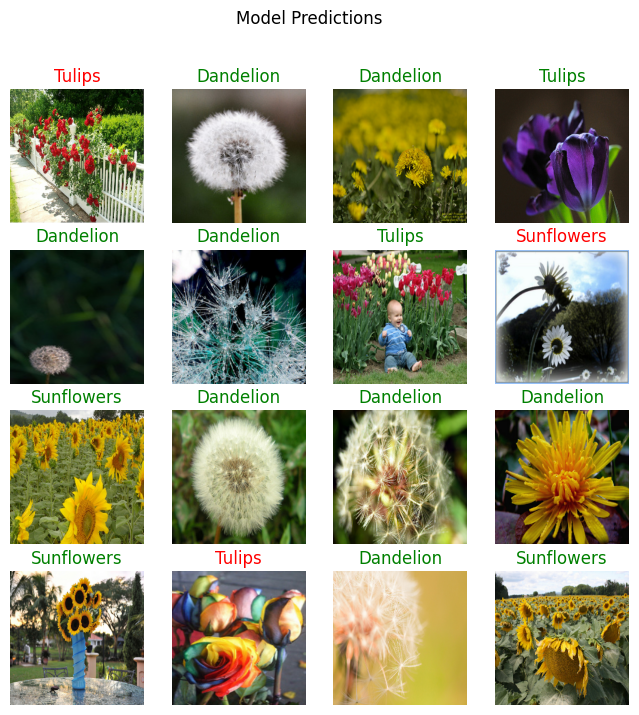

In [98]:
plt.figure(figsize=(8,8))

#Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i + 1)
  #Display each image
  plt.imshow(image_batch[i])
   #Set title color:green if predicted label is correct
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')
plt.suptitle("Model Predictions")